In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from asift import *
import open3d as o3d




In [2]:
import sys
sys.path.insert(0,'/Users/nikhilcr/Desktop/College/COMPUTER VISION/Project')

In [3]:
dataset_path = 'uncc-dataset/'
dataset_path_cereal_box_1 = 'uncc-dataset/cereal_box_1/'

adapted from https://github.com/opencv/opencv/blob/3.2.0/samples/python/asift.py

## Custom functions for loading datasets


In [4]:
import glob
import os
import numpy as np

def load_images(directory):
    num_poses, num_views_per_pose = 6, 5
    images = np.empty((num_poses, num_views_per_pose), dtype=object)

    image_files = glob.glob(os.path.join(directory, '*.png'))
    for image_file in image_files:
        file_name = os.path.basename(image_file)
        item_name = file_name.split('.')
        if 'separated' in item_name[0]:
            object_name,_,_, pose_idx, view_idx,_ = item_name[0].split('_')
        else:
            object_name,_,_, pose_idx, view_idx = item_name[0].split('_')
        
        pose_idx = int(pose_idx)-1
        view_idx = int(view_idx)-1
        image = cv2.imread(image_file, 0)
        images[pose_idx][view_idx] = image

    return images

def load_pcds(directory):
    num_poses, num_views_per_pose = 6, 5
    pcds = np.empty((num_poses, num_views_per_pose), dtype=object)

    pcd_files = glob.glob(os.path.join(directory, '*.pcd'))
    for pcd_file in pcd_files:
        file_name = os.path.basename(pcd_file)
        item_name = file_name.split('.')
        if 'separated' in item_name[0]:
            object_name,_,_, pose_idx, view_idx,_ = item_name[0].split('_')
        else:
            object_name,_,_, pose_idx, view_idx = item_name[0].split('_')
        pose_idx = int(pose_idx)-1
        view_idx = int(view_idx)-1
        pcd = o3d.io.read_point_cloud(pcd_file)
        pcds[pose_idx][view_idx] = pcd

    return pcds




In [5]:

directory_path = 'uncc-dataset/cereal_box_1/full/'
images_full = load_images(directory_path)

In [6]:
directory_path = 'uncc-dataset/cereal_box_1/full/'
pcds_full = load_pcds(directory_path)

In [7]:
directory_path = 'uncc-dataset/cereal_box_1/separated'
images_seperated = load_images(directory_path)

In [8]:
directory_path = 'uncc-dataset/cereal_box_1/separated/'
pcds_seperated = load_pcds(directory_path)

In [9]:
def display(img):
    new_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(new_img)

For each set of RGB-D images from different camera views of the same object pose, we match keypoints from the landmarks in the environment to register different camera views.

In [10]:
def view_reg(pose):
    imagesout_views = []
    h_values_views = []
    for i in range(0, 4):
        print("Printing image --> ${0}, ${1}".format(i, i+1))
        imgout, h, kp_pairs, kp1, kp2, n_inliers= find_asift(images_seperated[pose][i], images_seperated[pose][i+1])
        imagesout_views.append(imgout)
        h_values_views.append(h)
    return h_values_views, imagesout_views


# FPFH


In [11]:
import copy

In [12]:
def draw_registration_result(source, target, transformation):
    source_temp = copy.deepcopy(source)
    target_temp = copy.deepcopy(target)
    source_temp.transform(transformation)
    # #o3d.visualization.draw_plotly([source_temp, target_temp],
    #                                   zoom=0.4559,
    #                                   front=[0.6452, -0.3036, -0.7011],
    #                                   lookat=[1.9892, 2.0208, 1.8945],
    #                                   up=[-0.2779, -0.9482, 0.1556])

In [13]:
def preprocess_point_cloud(pcd):
    print(":: Estimate normals.")
    pcd.estimate_normals(
        o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

    print(":: Compute FPFH feature.")
    pcd_fpfh = o3d.pipelines.registration.compute_fpfh_feature(
            pcd,
            o3d.geometry.KDTreeSearchParamHybrid(radius=0.25, max_nn=100))
    return pcd_fpfh


In [14]:
def prepare_dataset():
    print(":: Load two point clouds")

    source = pcds_seperated[0][0]
    target = pcds_seperated[1][0]
    trans_init = np.asarray([[0.0, 0.0, 1.0, 0.0], [1.0, 0.0, 0.0, 0.0],
                             [0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0]])
    source.transform(trans_init)
    draw_registration_result(source, target, np.identity(4))

    source_fpfh = preprocess_point_cloud(source)
    target_fpfh = preprocess_point_cloud(target )
    return source, target, source_fpfh, target_fpfh

In [15]:
source, target, source_fpfh, target_fpfh = prepare_dataset()

:: Load two point clouds
:: Estimate normals.
:: Compute FPFH feature.
:: Estimate normals.
:: Compute FPFH feature.


In [16]:

def execute_global_registration(source_down, target_down, source_fpfh,
                                target_fpfh):
    distance_threshold = 1.5
    print(":: RANSAC registration on point clouds.")
    result = o3d.pipelines.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh, True,
        distance_threshold,
        o3d.pipelines.registration.TransformationEstimationPointToPoint(False),
        3, [
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnEdgeLength(
                0.9),
            o3d.pipelines.registration.CorrespondenceCheckerBasedOnDistance(
                distance_threshold)
        ], o3d.pipelines.registration.RANSACConvergenceCriteria(100000, 0.999))
    return result

In [17]:
result_ransac = execute_global_registration(source, target,
                                            source_fpfh, target_fpfh)
print(result_ransac)
draw_registration_result(source, target, result_ransac.transformation)

:: RANSAC registration on point clouds.
RegistrationResult with fitness=7.789634e-01, inlier_rmse=6.560808e-02, and correspondence_set size of 34237
Access transformation to get result.


# 1 Trying to get D from pcd


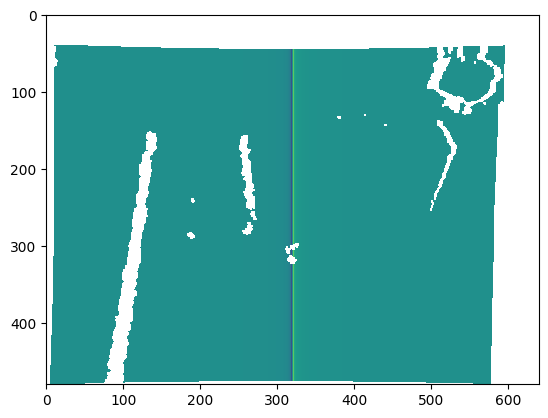

In [18]:
pcd = pcds_full[0][0]

point_cloud_array = np.asarray(pcd.points)

fx = 525.0
fy = 525.0
cx = 319.5
cy = 239.5

depth_values = (fx * point_cloud_array[:, 2]) / point_cloud_array[:, 0]
depth_values = depth_values.reshape(-1)  

width = 640 
height = 480 
depth_image = depth_values.reshape(height, width)

normalized_depth = (depth_image - np.min(depth_image)) / (np.max(depth_image) - np.min(depth_image))

plt.imshow(depth_image)

plt.show()


In [19]:
import skimage
import matplotlib.pyplot as plt


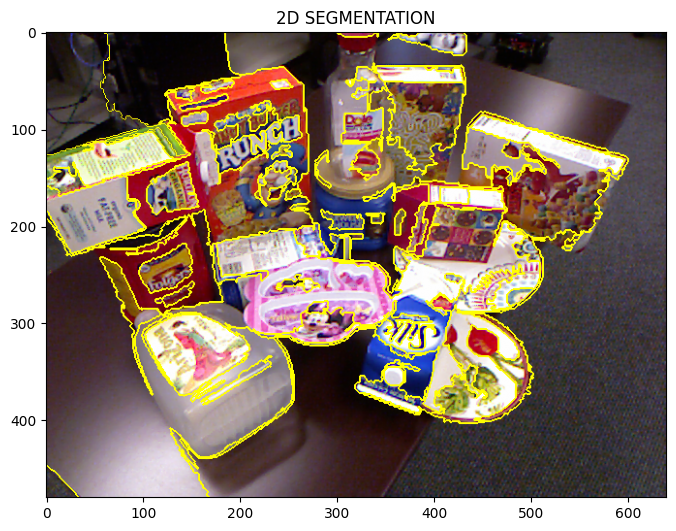

In [20]:
import skimage
import matplotlib.pyplot as plt
from skimage.segmentation import felzenszwalb, mark_boundaries

img = skimage.io.imread('uncc-dataset/scenes_testing/scene_1_1.png')
segments = felzenszwalb(img, scale=1000, sigma=0.5, min_size=100)

fig, ax = plt.subplots(figsize=(8, 8))
ax.imshow(mark_boundaries(img, segments))
ax.set_title("2D SEGMENTATION")

plt.show()


# SVM PART

## SEGMENTATION PCD

In [21]:
import open3d
import matplotlib.pyplot as plt
import cv2
import open3d as o3d
import numpy as np

In [22]:
pcd = o3d.io.read_point_cloud('uncc-dataset/scenes_testing/scene_1_1.pcd')

In [23]:
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=16), fast_normal_computation=True)
segment_models={}
segments={}
max_plane_idx=20
rest=pcd
d_threshold=0.01
for i in range(max_plane_idx):
    colors = plt.get_cmap("tab20")(i)
    segment_models[i], inliers = rest.segment_plane(distance_threshold=0.01,ransac_n=3,num_iterations=1000)
    segments[i]=rest.select_by_index(inliers)
    labels = np.array(segments[i].cluster_dbscan(eps=d_threshold*10, min_points=10))
    print(labels, segments)
    candidates=[len(np.where(labels==j)[0]) for j in np.unique(labels)]
    best_candidate=int(np.unique(labels)[np.where(candidates==np.max(candidates))[0]])
    rest = rest.select_by_index(inliers, invert=True)+segments[i].select_by_index(list(np.where(labels!=best_candidate)[0]))
    segments[i]=segments[i].select_by_index(list(np.where(labels==best_candidate)[0]))
    segments[i].paint_uniform_color(list(colors[:3]))


[0 0 0 ... 2 2 2] {0: PointCloud with 68435 points.}
[0 0 0 ... 1 1 1] {0: PointCloud with 60677 points., 1: PointCloud with 31171 points.}
[0 0 0 ... 4 4 4] {0: PointCloud with 60677 points., 1: PointCloud with 27177 points., 2: PointCloud with 25913 points.}
[0 0 0 ... 1 1 1] {0: PointCloud with 60677 points., 1: PointCloud with 27177 points., 2: PointCloud with 24924 points., 3: PointCloud with 18856 points.}
[0 0 0 ... 2 2 2] {0: PointCloud with 60677 points., 1: PointCloud with 27177 points., 2: PointCloud with 24924 points., 3: PointCloud with 18135 points., 4: PointCloud with 18163 points.}
[0 0 0 ... 0 0 0] {0: PointCloud with 60677 points., 1: PointCloud with 27177 points., 2: PointCloud with 24924 points., 3: PointCloud with 18135 points., 4: PointCloud with 17419 points., 5: PointCloud with 10168 points.}
[0 0 0 ... 5 5 5] {0: PointCloud with 60677 points., 1: PointCloud with 27177 points., 2: PointCloud with 24924 points., 3: PointCloud with 18135 points., 4: PointCloud wit

In [24]:
labels = np.array(rest.cluster_dbscan(eps=0.05, min_points=5))
max_label = labels.max()
print(f"point cloud has {max_label + 1} clusters")


# ####o3d.visualization.draw_geometries([segments.values()])
# ##o3d.visualization.draw_geometries([segments[i] for i in range(max_plane_idx)]+[rest])
##o3d.visualization.draw_plotly([segments[i] for i in range(max_plane_idx)]+[rest],zoom=0.3199,front=[0.30159062875123849, 0.94077325609922868, 0.15488309545553303],lookat=[-3.9559999108314514, -0.055000066757202148, -0.27599999308586121],up=[-0.044411423633999815, -0.138726419067636, 0.98753122516983349])
# ##o3d.visualization.draw_geometries([rest])

point cloud has 90 clusters


## 

In [25]:
len(segments)

20